In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

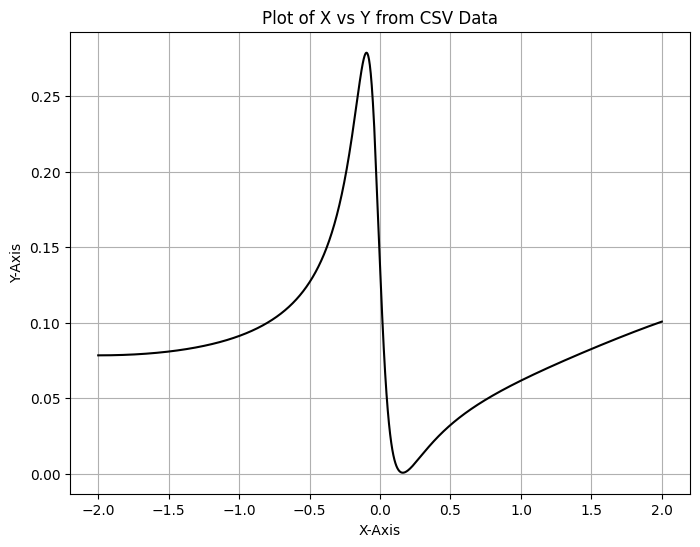

In [36]:
df = pd.read_csv('black_curve.csv')
x_values = df['1.99999647904564']
y_values = df['0.100654291710245']

# --- Step 4: Create the plot using matplotlib ---
plt.figure(figsize=(8, 6)) # Create a figure with a specific size
plt.plot(x_values, y_values, linestyle='-', color='black')

# --- Step 5: Add labels, a title, and a grid for clarity ---
plt.title('Plot of X vs Y from CSV Data')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.grid(True)

# --- Step 6: Display the plot ---
plt.show()

Step 0, Loss=0.014042
Step 500, Loss=0.000281
Step 1000, Loss=0.000281
Step 1500, Loss=0.000281
Step 2000, Loss=0.000281
Step 2500, Loss=0.000281
Step 3000, Loss=0.000281
Step 3500, Loss=0.000281
Step 4000, Loss=0.000281
Step 4500, Loss=0.000281

--- Fit Statistics ---
SSE       = 3.936800
R-square  = 0.894430
DFE       = 14019
Adj R-sq  = 0.894408
RMSE      = 0.016758


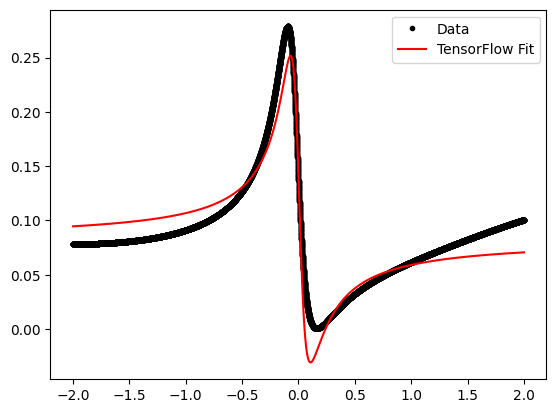

In [25]:
xx = x_values.to_numpy()
yy = y_values.to_numpy()
# Suppose xx and yy are your numpy arrays
# xx = np.array([...])
# yy = np.array([...])

# Define model function
def model_func(x, a, b, c, d):
    term1 = (a * b**2) / (1 + ((x - c) / d)**2)
    term2 = a * ((x - c) / d)**2 / (1 + ((x - c) / d)**2)
    term3 = a * (2 * b**2 * ((x - c) / d)) / (1 + ((x - c) / d)**2)
    return term1 + term2 + term3

# Convert data to tensors
X = tf.constant(xx, dtype=tf.float32)
Y = tf.constant(yy, dtype=tf.float32)

# Trainable parameters (initial guesses from MATLAB)
a = tf.Variable(0.07, dtype=tf.float32)
b = tf.Variable(-1.7, dtype=tf.float32)
c = tf.Variable(-0.03, dtype=tf.float32)
d = tf.Variable(0.09, dtype=tf.float32)
params = [a, b, c, d]

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training loop
for step in range(5000):
    with tf.GradientTape() as tape:
        y_pred = model_func(X, a, b, c, d)
        loss = tf.reduce_mean((Y - y_pred)**2)
    grads = tape.gradient(loss, params)
    optimizer.apply_gradients(zip(grads, params))
    if step % 500 == 0:
        print(f"Step {step}, Loss={loss.numpy():.6f}")

# Predictions
y_fit = model_func(X, a, b, c, d).numpy()

# --- Statistics ---
n = len(xx)         # number of data points
p = 4               # number of parameters

SSE = np.sum((yy - y_fit)**2)
SST = np.sum((yy - np.mean(yy))**2)
R2 = 1 - SSE/SST
DFE = n - p
Adj_R2 = 1 - (SSE/DFE) / (SST/(n-1))
RMSE = np.sqrt(SSE/DFE)

print("\n--- Fit Statistics ---")
print(f"SSE       = {SSE:.6f}")
print(f"R-square  = {R2:.6f}")
print(f"DFE       = {DFE}")
print(f"Adj R-sq  = {Adj_R2:.6f}")
print(f"RMSE      = {RMSE:.6f}")

# --- Plot ---
x_grid = np.linspace(xx.min(), xx.max(), 500)
y_grid = model_func(x_grid, a.numpy(), b.numpy(), c.numpy(), d.numpy())

plt.plot(xx, yy, "k.", label="Data")
plt.plot(x_grid, y_grid, "r-", label="TensorFlow Fit")
plt.legend()
plt.show()


In [33]:
xx = x_values.to_numpy()
yy = y_values.to_numpy()
# -------------------------
# Suppose xx and yy are your numpy arrays
# xx = np.array([...])
# yy = np.array([...])
# -------------------------

# Reshape for scaler
xx_reshaped = xx.reshape(-1, 1)
yy_reshaped = yy.reshape(-1, 1)

# Feature scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(xx_reshaped)
Y_scaled = scaler_y.fit_transform(yy_reshaped)

# Convert to tensors
X = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
Y = tf.convert_to_tensor(Y_scaled, dtype=tf.float32)

# Build neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='tanh',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(1)  # output layer
])

# Compile with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mse')

# Train model
history = model.fit(X, Y, epochs=500, batch_size=16, verbose=0)

# Predictions (unscale back to original units)
x_grid = np.linspace(xx.min(), xx.max(), 500).reshape(-1, 1)
x_grid_scaled = scaler_x.transform(x_grid)
y_pred_scaled = model.predict(x_grid_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluate stats
y_fit_scaled = model.predict(X_scaled)
y_fit = scaler_y.inverse_transform(y_fit_scaled)

n = len(xx)
p = np.sum([np.prod(v.shape) for v in model.trainable_variables])  # effective params
SSE = np.sum((yy - y_fit.flatten())**2)
SST = np.sum((yy - np.mean(yy))**2)
R2 = 1 - SSE/SST
DFE = n - p
Adj_R2 = 1 - (SSE/DFE) / (SST/(n-1))
RMSE = np.sqrt(SSE/DFE)

print("\n--- Neural Network Fit Statistics ---")
print(f"SSE       = {SSE:.6f}")
print(f"R-square  = {R2:.6f}")
print(f"DFE       = {DFE}")
print(f"Adj R-sq  = {Adj_R2:.6f}")
print(f"RMSE      = {RMSE:.6f}")

# Plot
plt.scatter(xx, yy, color='k', s=15, label="Data")
plt.plot(x_grid, y_pred, 'r-', lw=2, label="NN Fit")
plt.legend()
plt.show()


KeyboardInterrupt: 

Best start index: 3 start: [0.2, -2.0, 0.02, 0.15]

Fitted parameters (original units):
a = -2.1488665e-09
b = -2.0268091
c = -0.014109858   (center)
d = 1.1546453e-09   (width)

Fit statistics:
SSE     = 3.729101e+01
R2      = -1.354472e-14
DFE     = 14019
Adj_R2  = -2.139953e-04
RMSE    = 5.157552e-02


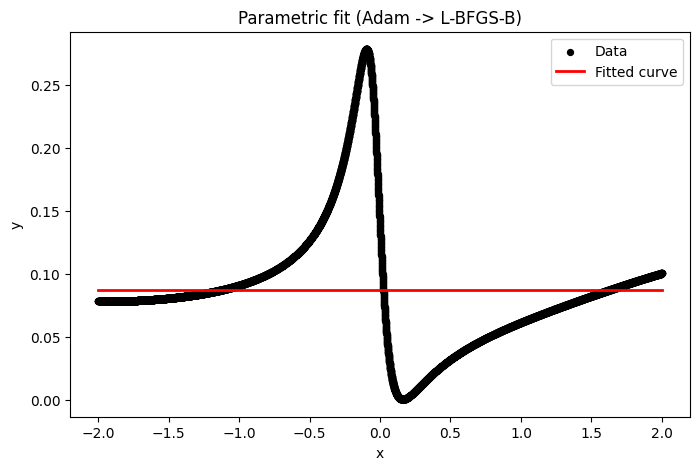

In [31]:
# fit_parametric_tf.py
# Requires: numpy, tensorflow (>=2.x), scipy, sklearn, matplotlib
xx= x_values.to_numpy()
yy= y_values.to_numpy()

# ---------- USER DATA: replace with your arrays ----------
# Example placeholders:
# xx = np.array([...])
# yy = np.array([...])
# -------------------------------------------------------
# Make sure xx and yy are 1-D numpy arrays
assert 'xx' in globals() and 'yy' in globals(), "Define xx and yy numpy arrays before running."
xx = np.asarray(xx).flatten()
yy = np.asarray(yy).flatten()
n = xx.size
p = 4  # number of parameters a,b,c,d

# ---------- Feature scaling ----------
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(xx.reshape(-1,1)).flatten()
Y_scaled = scaler_y.fit_transform(yy.reshape(-1,1)).flatten()

# Helper: model (works with numpy arrays)
def model_np(x, params):
    # params = [a,b,c,d]
    a, b, c, d = params
    z = (x - c) / d
    denom = 1.0 + z**2
    term1 = (a * (b**2)) / denom
    term2 = a * (z**2) / denom
    term3 = a * (2 * (b**2) * z) / denom
    return term1 + term2 + term3

# Loss for numpy (SSE + reg)
def loss_np(params, x_scaled, y_scaled, lambda_reg=1e-6):
    y_pred = model_np(x_scaled, params)
    mse = np.mean((y_scaled - y_pred)**2)
    reg = lambda_reg * np.sum(np.array(params)**2)
    return mse + reg

# ---------- TensorFlow-based Adam optimization (on scaled data) ----------
def adam_optimize(initial_params, Xs, Ys, lr=0.01, steps=3000, lambda_reg=1e-6, verbose=False):
    # create TF variables
    a = tf.Variable(initial_params[0], dtype=tf.float32)
    b = tf.Variable(initial_params[1], dtype=tf.float32)
    c = tf.Variable(initial_params[2], dtype=tf.float32)
    d = tf.Variable(initial_params[3], dtype=tf.float32)
    vars_tf = [a,b,c,d]

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    X_tf = tf.constant(Xs.reshape(-1,1), dtype=tf.float32)
    Y_tf = tf.constant(Ys.reshape(-1,1), dtype=tf.float32)

    @tf.function
    def training_step():
        with tf.GradientTape() as tape:
            z = (X_tf - c) / d
            denom = 1.0 + tf.square(z)
            term1 = (a * tf.square(b)) / denom
            term2 = a * tf.square(z) / denom
            term3 = a * (2.0 * tf.square(b) * z) / denom
            y_pred = term1 + term2 + term3
            data_loss = tf.reduce_mean(tf.square(Y_tf - y_pred))
            reg = tf.constant(lambda_reg, dtype=tf.float32) * (tf.reduce_sum([tf.square(v) for v in vars_tf]))
            loss = data_loss + reg
        grads = tape.gradient(loss, vars_tf)
        opt.apply_gradients(zip(grads, vars_tf))
        return loss, data_loss, reg

    for step in range(steps):
        loss_val, dl, reg_val = training_step()
        if verbose and (step % max(1, steps//10) == 0 or step < 10):
            print(f"Adam step {step:4d}: loss={loss_val.numpy():.6e}, data={dl.numpy():.6e}, reg={reg_val.numpy():.6e}")
    return np.array([a.numpy(), b.numpy(), c.numpy(), d.numpy()])

# ---------- SciPy L-BFGS-B polish (on scaled data) ----------
def lbfgs_refine(params0, Xs, Ys, lambda_reg=1e-6, bounds=None, maxiter=1000):
    # objective expects params as numpy array
    fun = lambda p: loss_np(p, Xs, Ys, lambda_reg=lambda_reg)
    res = minimize(fun, params0, method='L-BFGS-B', bounds=bounds, options={'maxiter': maxiter})
    return res.x, res.fun, res

# ---------- Multiple starting guesses ----------
# Good practice: explore several initial guesses (domain-specific)
# We generate a small set of plausible starts around rough guesses
initial_grid = [
    [0.07, -1.7, -0.03, 0.09],
    [0.05, -1.0,  0.0,   0.1],
    [0.1,   1.0,  0.0,   0.05],
    [0.2,  -2.0,  0.02,  0.15],
    [0.01,  0.5,  0.0,   0.05]
]

best = {'SSE': np.inf, 'params_scaled': None, 'params_unscaled': None, 'y_fit': None, 'stats': None, 'res': None}

# Optional bounds on parameters in scaled domain (if you want)
# We'll place bounds in the scaled parameter space or the actual param space: here actual space
bounds = [
    (None, None),   # a
    (None, None),   # b
    (None, None),   # c
    (1e-6, None)    # d must be positive
]

lambda_reg = 1e-6

for start_idx, start in enumerate(initial_grid):
    # Transform start for scaled domain if needed:
    # Our model uses scaled x and scaled y, but params themselves are in the scale of y.
    # To give reasonable starts we scale 'c' (the x-center) using scaler_x, and scale a,b,d with scaler_y scale if appropriate.
    # Simpler approach: convert initial 'start' into the scaled y/x units:
    a0, b0, c0, d0 = start
    # scale c (center) to scaled x units:
    c0_s = (c0 - scaler_x.mean_[0]) / np.sqrt(scaler_x.var_[0])
    # scale a and d roughly to scaled y units: (a and terms produce y), but to keep things simple we'll scale a and d by y-scale
    a0_s = a0 / np.sqrt(scaler_y.var_[0])
    d0_s = d0 / np.sqrt(scaler_x.var_[0])  # since d is in x-units, scale with x
    start_scaled = np.array([a0_s, b0, c0_s, d0_s], dtype=float)

    # Run Adam on scaled data
    params_after_adam = adam_optimize(start_scaled, X_scaled, Y_scaled,
                                      lr=0.01, steps=1500, lambda_reg=lambda_reg, verbose=False)

    # Polish with L-BFGS-B (in scaled parameter space)
    # choose bounds in scaled space accordingly (we only enforce positive d)
    # convert bounds to scaled: for d, multiply by 1/x_std; but to avoid complexity, just set d>1e-6
    bounds_scaled = [(None, None), (None, None), (None, None), (1e-9, None)]
    params_refined, funval, res = lbfgs_refine(params_after_adam, X_scaled, Y_scaled,
                                              lambda_reg=lambda_reg, bounds=bounds_scaled, maxiter=1000)

    # compute predictions on scaled x, then unscale y predictions back to original units
    y_pred_scaled = model_np(X_scaled, params_refined)
    # invert scaler_y: y_original = y_scaled * y_std + y_mean
    y_pred = y_pred_scaled * np.sqrt(scaler_y.var_[0]) + scaler_y.mean_[0]
    SSE = np.sum((yy - y_pred)**2)

    # Compute statistics
    SST = np.sum((yy - np.mean(yy))**2)
    R2 = 1 - SSE / SST
    DFE = n - p
    Adj_R2 = 1 - (SSE/DFE) / (SST/(n-1))
    RMSE = np.sqrt(SSE / DFE)

    if SSE < best['SSE']:
        # Convert refined params back to original (un-scale parameters)
        # params_refined = [a_s, b, c_s, d_s]
        a_s, b_s, c_s, d_s = params_refined
        # unscale c, a, d properly:
        c_orig = c_s * np.sqrt(scaler_x.var_[0]) + scaler_x.mean_[0]
        a_orig = a_s * np.sqrt(scaler_y.var_[0])
        d_orig = d_s * np.sqrt(scaler_x.var_[0])
        params_orig = np.array([a_orig, b_s, c_orig, d_orig])

        best.update({
            'SSE': SSE,
            'params_scaled': params_refined.copy(),
            'params_unscaled': params_orig.copy(),
            'y_fit': y_pred.copy(),
            'stats': {'SSE': SSE, 'R2': R2, 'DFE': DFE, 'Adj_R2': Adj_R2, 'RMSE': RMSE},
            'res': res,
            'start_idx': start_idx,
            'start': start
        })

# ---------- Report best result ----------
print("Best start index:", best['start_idx'], "start:", best['start'])
print("\nFitted parameters (original units):")
print(f"a = {best['params_unscaled'][0]:.8g}")
print(f"b = {best['params_unscaled'][1]:.8g}")
print(f"c = {best['params_unscaled'][2]:.8g}   (center)")
print(f"d = {best['params_unscaled'][3]:.8g}   (width)")

print("\nFit statistics:")
for k,v in best['stats'].items():
    if isinstance(v, float):
        print(f"{k:7s} = {v:.6e}")
    else:
        print(f"{k:7s} = {v}")

# ---------- Plot ----------
x_grid = np.linspace(xx.min(), xx.max(), 500)
# compute model using original-params (no scaling) but remember model_np expects inputs in scaled x units:
# we can compute y from original x by scaling x to X_scaled domain used in fit:
x_grid_scaled = (x_grid.reshape(-1,1) - scaler_x.mean_[0]) / np.sqrt(scaler_x.var_[0])
y_grid_scaled = model_np(x_grid_scaled.flatten(), best['params_scaled'])
y_grid = y_grid_scaled * np.sqrt(scaler_y.var_[0]) + scaler_y.mean_[0]

plt.figure(figsize=(8,5))
plt.scatter(xx, yy, color='k', s=18, label='Data')
plt.plot(x_grid, y_grid, 'r-', lw=2, label='Fitted curve')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Parametric fit (Adam -> L-BFGS-B)')
plt.show()


Epoch 0: Loss = 0.002634
Epoch 500: Loss = 0.000107
Epoch 1000: Loss = 0.000043
Epoch 1500: Loss = 0.000012
Epoch 2000: Loss = 0.000002
Epoch 2500: Loss = 0.000002
Epoch 3000: Loss = 0.000001
Epoch 3500: Loss = 0.000001
Epoch 4000: Loss = 0.000001
Epoch 4500: Loss = 0.000001

Learned Parameters:
a = 0.086354, b = -1.518956, c = -0.024619, d = 0.118835

Goodness of Fit:
SSE      = 0.014801
R-square = 0.999603
DFE      = 14019
Adj R-sq = 0.999603
RMSE     = 0.001028


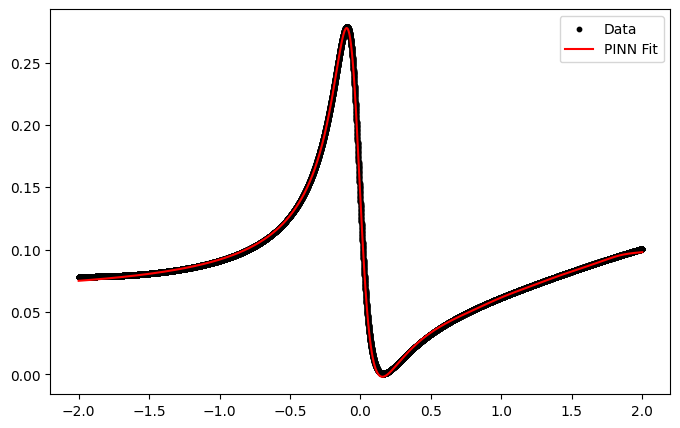

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Load your dataset
# =========================
df = pd.read_csv("black_curve.csv")

# Replace with actual column names in your file
x_values = df['1.99999647904564'].values  
y_values = df['0.100654291710245'].values  

# Convert to torch tensors
x_train_t = torch.tensor(x_values, dtype=torch.float32).view(-1,1)
y_train_t = torch.tensor(y_values, dtype=torch.float32).view(-1,1)

N = len(x_values)   # number of data points
p = 4               # number of parameters (a,b,c,d)

# =========================
# 2. Define PINN model
# =========================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
        # Trainable parameters a,b,c,d
        self.a = nn.Parameter(torch.tensor(0.05))
        self.b = nn.Parameter(torch.tensor(-1.0))
        self.c = nn.Parameter(torch.tensor(0.0))
        self.d = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # Base physical model
        f_base = (self.a*(self.b**2)/(1+((x-self.c)/self.d)**2) +
                  self.a*((x-self.c)/self.d)**2/(1+((x-self.c)/self.d)**2) +
                  self.a*(2*self.b*(x-self.c)/self.d)/(1+((x-self.c)/self.d)**2))
        # Small NN correction term
        correction = self.hidden(x) * 0.001
        return f_base + correction

# =========================
# 3. Training loop
# =========================
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# =========================
# 4. Extract learned parameters
# =========================
a_fit = model.a.item()
b_fit = model.b.item()
c_fit = model.c.item()
d_fit = model.d.item()

print("\nLearned Parameters:")
print(f"a = {a_fit:.6f}, b = {b_fit:.6f}, c = {c_fit:.6f}, d = {d_fit:.6f}")

# =========================
# 5. Goodness-of-fit metrics
# =========================
y_pred_np = model(x_train_t).detach().numpy().flatten()
y_true_np = y_train_t.numpy().flatten()

# SSE (Sum of Squared Errors)
SSE = np.sum((y_true_np - y_pred_np)**2)

# SST (Total Sum of Squares)
SST = np.sum((y_true_np - np.mean(y_true_np))**2)

# R-square
R2 = 1 - SSE/SST

# Degrees of freedom
DFE = N - p

# Adjusted R-square
Adj_R2 = 1 - (1-R2)*(N-1)/(DFE)

# RMSE
RMSE = np.sqrt(SSE/DFE)

print("\nGoodness of Fit:")
print(f"SSE      = {SSE:.6f}")
print(f"R-square = {R2:.6f}")
print(f"DFE      = {DFE}")
print(f"Adj R-sq = {Adj_R2:.6f}")
print(f"RMSE     = {RMSE:.6f}")

# =========================
# 6. Plot results
# =========================
plt.figure(figsize=(8,5))
plt.scatter(x_values, y_values, label="Data", s=10, color="black")
plt.plot(x_values, y_pred_np, 'r-', label="PINN Fit")
plt.legend()
plt.show()


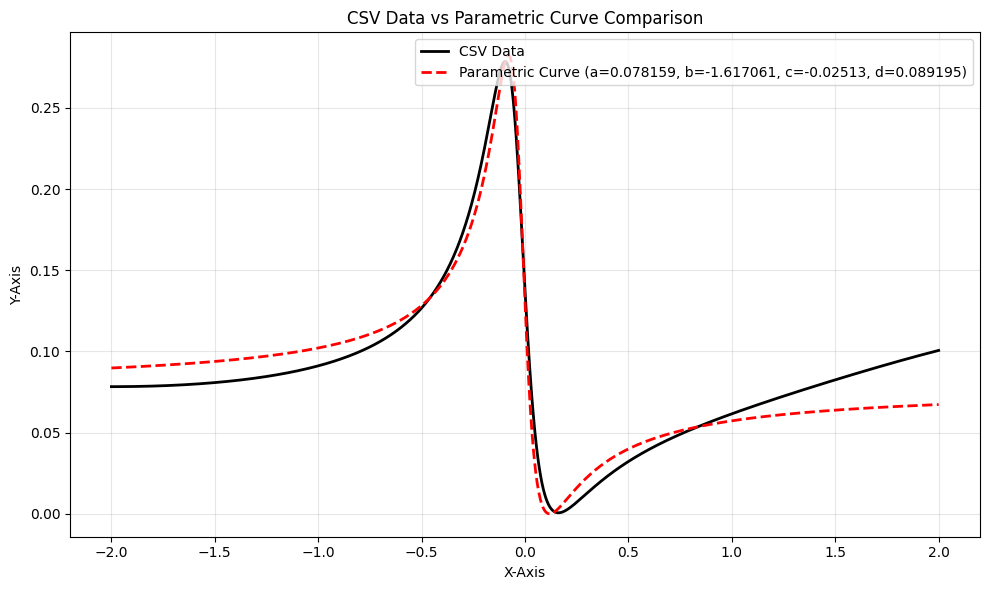

Current parameters: a=0.078159, b=-1.617061, c=-0.02513, d=0.089195
To change parameters, modify the values in the code above.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read CSV data
df = pd.read_csv('black_curve.csv')
x_values = df['1.99999647904564']
y_values = df['0.100654291710245']

# Define the parametric equation function
def parametric_curve(x, a, b, c, d):
    """
    Calculate y values for the parametric equation:
    a*(b^2)/(1+ ((x-c)/d)^2) + a*(((x-c)/d)^2)/(1+((x-c)/d)^2) + a*(2*b*((x-c)/d))/(1+((x-c)/d)^2)
    """
    term = (x - c) / d
    denominator = 1 + term**2
    
    term1 = a * (b**2) / denominator
    term2 = a * (term**2) / denominator
    term3 = a * (2 * b * term) / denominator
    
    return term1 + term2 + term3

# Set parameters for the curve (you can modify these values)
# a = 0.078159, b = -1.617061, c = -0.025130, d = 0.089195
a = 0.078159  # Parameter a
b = -1.617061  # Parameter b
c = -0.025130  # Parameter c
d = 0.089195  # Parameter d

# Generate x values for the curve (adjust range as needed)
x_curve = np.linspace(min(x_values), max(x_values), 1000)
y_curve = parametric_curve(x_curve, a, b, c, d)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot CSV data
plt.plot(x_values, y_values, linestyle='-', color='black', linewidth=2, label='CSV Data')

# Plot parametric curve
plt.plot(x_curve, y_curve, linestyle='--', color='red', linewidth=2, 
         label=f'Parametric Curve (a={a}, b={b}, c={c}, d={d})')

# Add labels, title, and formatting
plt.title('CSV Data vs Parametric Curve Comparison')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.grid(True, alpha=0.3)
plt.legend()

# Optional: Set axis limits if needed
# plt.xlim([min_x, max_x])
# plt.ylim([min_y, max_y])

# Display the plot
plt.tight_layout()
plt.show()

# Print parameter values for reference
print(f"Current parameters: a={a}, b={b}, c={c}, d={d}")
print("To change parameters, modify the values in the code above.")

In [ ]:
# Set parameters for the curve (you can modify these values)
a = 0.086354  # Parameter a
b = -1.518956  # Parameter b
c = -0.024619  # Parameter c
d = 0.118835  # Parameter d

Epoch 0: Loss = 0.002636
Epoch 1000: Loss = 0.000184
Epoch 2000: Loss = 0.000180
Epoch 3000: Loss = 0.000180
Epoch 4000: Loss = 0.000180
Epoch 5000: Loss = 0.000180
Epoch 6000: Loss = 0.000180
Epoch 7000: Loss = 0.000180
Epoch 8000: Loss = 0.000180
Epoch 9000: Loss = 0.000180

Best Fit Parameters:
a = 0.078159, b = -1.617061, c = -0.025130, d = 0.089195

Goodness of Fit:
SSE      = 2.522841
R-square = 0.932347
DFE      = 14019
Adj R-sq = 0.932333
RMSE     = 0.013415


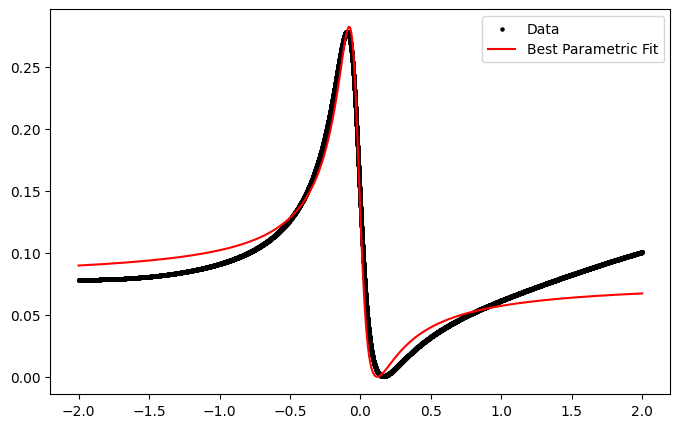

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Load your dataset
# =========================
df = pd.read_csv("black_curve.csv")

# Replace with actual column names
x_values = df['1.99999647904564'].values  
y_values = df['0.100654291710245'].values  

x_train_t = torch.tensor(x_values, dtype=torch.float32).view(-1,1)
y_train_t = torch.tensor(y_values, dtype=torch.float32).view(-1,1)

N = len(x_values)   # number of data points
p = 4               # number of parameters (a,b,c,d)

# =========================
# 2. Define parametric model (no NN correction)
# =========================
class ParamFit(nn.Module):
    def __init__(self):
        super(ParamFit, self).__init__()
        # Trainable parameters a,b,c,d
        self.a = nn.Parameter(torch.tensor(0.05))
        self.b = nn.Parameter(torch.tensor(-1.0))
        self.c = nn.Parameter(torch.tensor(0.0))
        self.d = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        return (self.a*(self.b**2)/(1+((x-self.c)/self.d)**2) +
                self.a*((x-self.c)/self.d)**2/(1+((x-self.c)/self.d)**2) +
                self.a*(2*self.b*(x-self.c)/self.d)/(1+((x-self.c)/self.d)**2))

# =========================
# 3. Training loop
# =========================
model = ParamFit()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# =========================
# 4. Extract learned parameters
# =========================
a_fit = model.a.item()
b_fit = model.b.item()
c_fit = model.c.item()
d_fit = model.d.item()

print("\nBest Fit Parameters:")
print(f"a = {a_fit:.6f}, b = {b_fit:.6f}, c = {c_fit:.6f}, d = {d_fit:.6f}")

# =========================
# 5. Goodness-of-fit metrics
# =========================
y_pred_np = model(x_train_t).detach().numpy().flatten()
y_true_np = y_train_t.numpy().flatten()

SSE = np.sum((y_true_np - y_pred_np)**2)                  # Sum of Squared Errors
SST = np.sum((y_true_np - np.mean(y_true_np))**2)         # Total Sum of Squares
R2 = 1 - SSE/SST                                          # R-square
DFE = N - p                                               # Degrees of freedom
Adj_R2 = 1 - (1-R2)*(N-1)/(DFE)                           # Adjusted R-square
RMSE = np.sqrt(SSE/DFE)                                   # Root Mean Square Error

print("\nGoodness of Fit:")
print(f"SSE      = {SSE:.6f}")
print(f"R-square = {R2:.6f}")
print(f"DFE      = {DFE}")
print(f"Adj R-sq = {Adj_R2:.6f}")
print(f"RMSE     = {RMSE:.6f}")

# =========================
# 6. Plot results
# =========================
plt.figure(figsize=(8,5))
plt.scatter(x_values, y_values, label="Data", s=5, color="black")
plt.plot(x_values, y_pred_np, 'r-', label="Best Parametric Fit")
plt.legend()
plt.show()

[Adam] Epoch 0, Loss = 2.156790e-04
[Adam] Epoch 500, Loss = 1.799074e-04
[Adam] Epoch 1000, Loss = 1.799074e-04
[Adam] Epoch 1500, Loss = 1.799074e-04
[Adam] Epoch 2000, Loss = 1.799077e-04
[Adam] Epoch 2500, Loss = 1.799074e-04
[Adam] Epoch 3000, Loss = 1.799074e-04
[Adam] Epoch 3500, Loss = 1.799074e-04
[Adam] Epoch 4000, Loss = 1.799096e-04
[Adam] Epoch 4500, Loss = 1.799074e-04

Switching to LBFGS...

Best Fit Parameters:
a = 0.078156, b = -1.617093, c = -0.025115, d = 0.089212

Goodness of Fit:
SSE      = 2.522842
R-square = 0.932347
DFE      = 14019
Adj R-sq = 0.932333
RMSE     = 0.013415


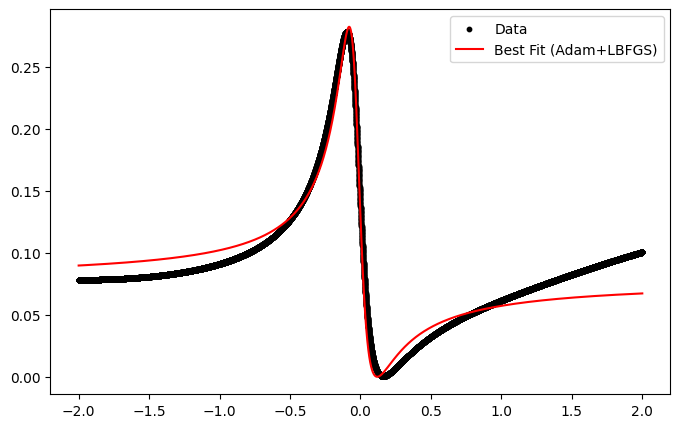

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Load dataset
# =========================
df = pd.read_csv("black_curve.csv")

# Replace with actual column names
x_values = df['1.99999647904564'].values  
y_values = df['0.100654291710245'].values  

# Normalize X for stability
x_mean, x_std = np.mean(x_values), np.std(x_values)
x_scaled = (x_values - x_mean) / x_std

# Torch tensors
x_train_t = torch.tensor(x_scaled, dtype=torch.float32).view(-1,1)
y_train_t = torch.tensor(y_values, dtype=torch.float32).view(-1,1)

N = len(x_values)   # number of data points
p = 4               # number of parameters (a,b,c,d)

# =========================
# 2. Define parametric model
# =========================
class ParamFit(nn.Module):
    def __init__(self, a0, b0, c0, d0):
        super(ParamFit, self).__init__()
        # Trainable parameters with good initial guesses
        self.a = nn.Parameter(torch.tensor(a0, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(b0, dtype=torch.float32))
        self.c = nn.Parameter(torch.tensor(c0, dtype=torch.float32))
        self.d = nn.Parameter(torch.tensor(d0, dtype=torch.float32))

    def forward(self, x):
        # Rescale x back to original scale
        x_orig = x * x_std + x_mean
        return (self.a*(self.b**2)/(1+((x_orig-self.c)/self.d)**2) +
                self.a*((x_orig-self.c)/self.d)**2/(1+((x_orig-self.c)/self.d)**2) +
                self.a*(2*self.b*(x_orig-self.c)/self.d)/(1+((x_orig-self.c)/self.d)**2))

# =========================
# 3. Model with initial guess
# =========================
# 👉 Replace these with MATLAB results if available
a0, b0, c0, d0 = 0.0713, -1.7316, -0.0317, 0.0946
model = ParamFit(a0, b0, c0, d0)

loss_fn = nn.MSELoss()

# =========================
# 4. Adam optimizer (warm-up)
# =========================
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"[Adam] Epoch {epoch}, Loss = {loss.item():.6e}")

# =========================
# 5. LBFGS optimizer (refine)
# =========================
optimizer = optim.LBFGS(model.parameters(), max_iter=5000, tolerance_grad=1e-12, tolerance_change=1e-12, history_size=100)

def closure():
    optimizer.zero_grad()
    y_pred = model(x_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    return loss

print("\nSwitching to LBFGS...")
optimizer.step(closure)

# =========================
# 6. Extract learned parameters
# =========================
a_fit = model.a.item()
b_fit = model.b.item()
c_fit = model.c.item()
d_fit = model.d.item()

print("\nBest Fit Parameters:")
print(f"a = {a_fit:.6f}, b = {b_fit:.6f}, c = {c_fit:.6f}, d = {d_fit:.6f}")

# =========================
# 7. Goodness-of-fit metrics
# =========================
y_pred_np = model(x_train_t).detach().numpy().flatten()
y_true_np = y_train_t.numpy().flatten()

SSE = np.sum((y_true_np - y_pred_np)**2)
SST = np.sum((y_true_np - np.mean(y_true_np))**2)
R2 = 1 - SSE/SST
DFE = N - p
Adj_R2 = 1 - (1-R2)*(N-1)/(DFE)
RMSE = np.sqrt(SSE/DFE)

print("\nGoodness of Fit:")
print(f"SSE      = {SSE:.6f}")
print(f"R-square = {R2:.6f}")
print(f"DFE      = {DFE}")
print(f"Adj R-sq = {Adj_R2:.6f}")
print(f"RMSE     = {RMSE:.6f}")

# =========================
# 8. Plot results
# =========================
plt.figure(figsize=(8,5))
plt.scatter(x_values, y_values, label="Data", s=10, color="black")
plt.plot(x_values, y_pred_np, 'r-', label="Best Fit (Adam+LBFGS)")
plt.legend()
plt.show()
